# This notebook plots numerical solutions and computes/plots analytic solutions for the default parameter set-up throughout the paper.

Here, we create figures: 3,4,5 in the main text and all appendix figures (A1, B1, B2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import copy
from matplotlib import rcParams
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
L_x_h =3795751.714012305 #zonal width of domain, h variable
L_y_h = 13785809.584401697 #meridional width of domain, h variable
nx = 128 #number grid points, zonal
ny = 129 #number grid points, meridional

L_x =(ny/(ny-1))*L_x_h 
L_y = (nx/(nx-1))*L_y_h

dx = L_x / nx #grid spacing, zonal
dy = L_y / ny #grid spacing, meridional

H1=250 #layer thickness 1
H2=250 #layer thickness 2

#Set coriolis values
omega=7.2921E-5
ref_lat=0
f0=2*omega*np.sin(np.deg2rad(ref_lat))
beta=2*omega*np.cos(np.deg2rad(ref_lat))/(6.637E6)

# Set densities and reduced gravity
rho0 = 1024.0 #reference density of fluid
rho3=1030 #density abyssal fluid
rho2=1028 #density bottom active layer
rho1=1026 #density top active layer

g1= 9.8*(rho2-rho1)/rho1 #reduced gravity 1
g2= 9.8*(rho3-rho2)/rho1 #reduced gravity 2

# positions of the u,v,h points
ux = (-L_x/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-L_x/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-L_y/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-L_y/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

hx = vx
hy = uy

#inverse f
f_v_inv=1/(f0 + beta*vy)


# 1. Load in numerical results. In the next section, we will do analytics. 

In [38]:
#These have to be created using the execute files in the subfodler 250m_rhodiff2
#For ease of being able to run this main notebook without running the execute files, we have made these available on google drive:
#https://drive.google.com/drive/folders/1Z1Tk683nuRAuMG4KPhCP8TACMFuEWxJC?usp=sharing

# Load in top perturbation
h2=xr.open_dataset("./output_files/h2_xr_control_years600to675_toplayerpert_wind_fix_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h2_xr_top=(h2.to_array()).squeeze()

h1=xr.open_dataset("./output_files/h1_xr_control_years600to675_toplayerpert_wind_fix_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h1_xr_top=(h1.to_array()).squeeze()



# Load in bottom perturbation
h2=xr.open_dataset("./output_files/h2_xr_control_years600to675_bottomlayerpert_wind_fix_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h2_xr_bottom=(h2.to_array()).squeeze()

h1=xr.open_dataset("./output_files/h1_xr_control_years600to675_bottomlayerpert_wind_fix_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_delta_rho2_mitdomainsize_mod.nc")
h1_xr_bottom=(h1.to_array()).squeeze()

# 2. Analytics to predict each layer thickness. Bottom layer perturbation

In [4]:
c1=np.zeros(np.size(h2_xr_top[:,10,10])-30)
for j in range(0,np.size(h2_xr_top[:,10,10])-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
wbc=12 #width of western boundary

#form a lag for each x point (other than wbc) throughout analytic domain
lag_l1_grid=np.zeros([129-30,128-wbc])
lag_l2_grid=np.zeros([129-30,128-wbc])

#creates an array for each point in analytic domain of the lag off the eastern boundary
for j in range(30,129):
    for i in range(wbc,128):
        lag_l1_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3+np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
        lag_l2_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3-np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
lag_l1_grid=lag_l1_grid.astype('int')
lag_l2_grid=lag_l2_grid.astype('int')

/state/partition1/job-55926434/ipykernel_387081/263420700.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


In [16]:
# predict eastern boundary height
c1=np.zeros(np.size(h1_xr_bottom[:,10,10])-ny//7-7-30) 
for j in range(0,np.size(h1_xr_bottom[:,10,10])-ny//7-7-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1]=1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

last_grid_pt=ny-ny//7-7


lag_l1=(((128-wbc)/128)*L_x/(((3+np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(((3-np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1

#Coefficients for the h_1 lag equation

b1_1=(5+np.sqrt(5))/10
b2_1=np.sqrt(5)/5
b3_1=(5-np.sqrt(5))/10
b4_1=-b2_1

#Coefficients for the h_2 lag equation
b1_2=1/np.sqrt(5)
b2_2=-(1-np.sqrt(5))/(2*np.sqrt(5))
b3_2=-1/np.sqrt(5)
b4_2=(1+np.sqrt(5))/(2*np.sqrt(5))


h1_east_est=np.array(h1_xr_bottom[30:-ny//7,-1,0].mean('y'))*np.ones(4444)
h2_east_est=np.array(h2_xr_bottom[30:-ny//7,-1,0].mean('y'))*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=np.array(h1_xr_bottom[30:-ny//7,wbc,0].mean('y'))*np.ones(np.size(c1))
    est_h2_bd=np.array(h2_xr_bottom[30:-ny//7,wbc,0].mean('y'))*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*np.array(h1_xr_bottom[j+30,wbc,0])+b4_1*np.array(h2_xr_bottom[j+30,wbc,0])
    #estimate western bdd of bottom layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*np.array(h1_xr_bottom[j+30,wbc,0])+b4_2*np.array(h2_xr_bottom[j+30,wbc,0])
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_bottom[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_bottom[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    #estimate of flux at southern boundary using only numerical information from wbc
    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_bottom[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_bottom[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])

    #estimate of flux at northern boundary using only numerical information from wbc
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

    #update h1 or h2 eastern boundary height
    h1_east_est[k]=((-dy*c1_cap*est_h1_bd).sum()-T_s1+T_s2+T_n1-T_n2)/(-c1_cap*dy).sum()
    h2_east_est[k]=((-dy*c1_cap*(est_h1_bd+est_h2_bd)).sum()-T_s2+T_n2+(h1_east_est[k]*c1_cap*dy).sum())/(-c1_cap*dy).sum()

/state/partition1/job-55926434/ipykernel_387081/3344888499.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


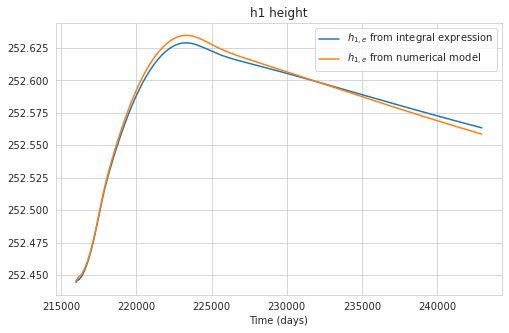

In [17]:
#Check our solution for eastern boundary height vs the true eastern boundary height

fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

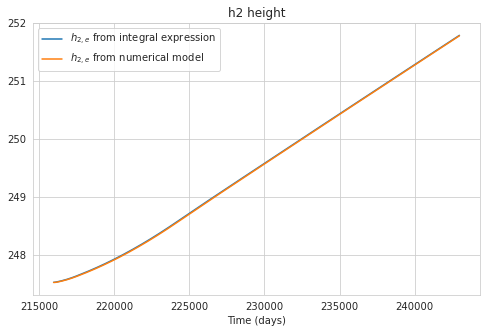

In [18]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h2_xr_bottom[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h2_xr_bottom[24:,127,:].time[0:4444],h2_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [19]:
#Predict the height throughout the basin using lag equation at the END TIME

pred_h1_bottompert_grid=np.zeros([129-30,128-wbc]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid=np.zeros([129-30,128-wbc]) #h2 height in the bottom perturbation experiment
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0:
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*h1_xr_bottom[j-30,i-wbc,0]+b4_1*h2_xr_bottom[j-30,i-wbc,0]
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*h1_xr_bottom[j-30,i-wbc,0]+b4_2*h2_xr_bottom[j-30,i-wbc,0]

#convert these all to xarrays
h1_pred_bottompert=xr.DataArray(pred_h1_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_bottompert=xr.DataArray(pred_h2_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

Text(0.5, 1.05, 'Prediction throughout basin at 75 years with a bottom layer perturbation. Wind.')

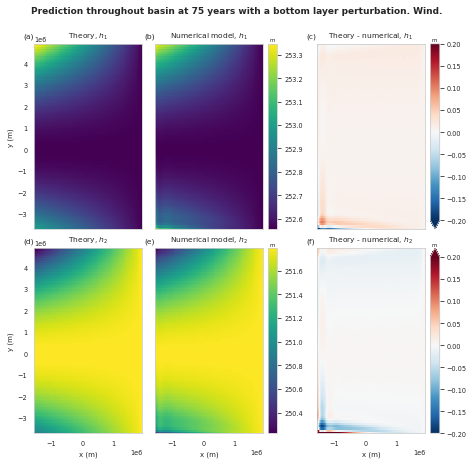

In [22]:
import seaborn as sns
sns.set_style("whitegrid")

scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)
#fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(21,16),  gridspec_kw={'width_ratios': [0.8, 1, 1]})

(h1_pred_bottompert[:-ny//7,:]).plot(ax=ax7,edgecolor='face',add_colorbar=False)
ax7.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax7.set_title(r'Theory, $h_1$')
ax7.set_title('(a)',loc='left',x=-0.1)

(h1_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax8,edgecolor='face')
ax8.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax8.set_title('(b)',loc='left',x=-0.1)
#ax8.set_title('m',loc='right',x=1.12)
ax8.set_title(r'Numerical model, $h_1$')



(h1_pred_bottompert[:-ny//7]-h1_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax9,vmax=0.2,edgecolor='face')
ax9.set_title(r'Theory - numerical, $h_1$')
ax9.set_title('(c)',loc='left',x=-0.1)
#ax9.set_title('m',loc='right',x=1.12)



(h2_pred_bottompert[:-ny//7,:]).plot(ax=ax10,edgecolor='face',add_colorbar=False)
ax10.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax10.set_title(r'Theory, $h_2$')
ax10.set_title('(d)',loc='left',x=-0.1)


(h2_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax11,edgecolor='face')
ax11.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax11.set_title(r'Numerical model, $h_2$')
ax11.set_title('(e)',loc='left',x=-0.1)

(h2_pred_bottompert[:-ny//7]-h2_xr_bottom[30:-ny//7,wbc:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax12,vmax=0.2,edgecolor='face')
ax12.set_title(r'Theory - numerical, $h_2$')
ax12.set_title('(f)',loc='left',x=-0.1)


fig.text(0.57, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.57, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)


fig.text(0.918, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.918, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)



ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('x (m)')
ax11.set_xlabel('x (m)')
ax12.set_xlabel('x (m)')
ax7.set_ylabel('y (m)')
ax8.set_ylabel('')
ax9.set_ylabel('')
ax10.set_ylabel('y (m)')
ax11.set_ylabel('')
ax12.set_ylabel('')


ax8.set_yticks([])
ax9.set_yticks([])
ax11.set_yticks([])
ax12.set_yticks([])


ax7.set_xticks([])
ax8.set_xticks([])
ax9.set_xticks([])


fig.suptitle('Prediction throughout basin at 75 years with a bottom layer perturbation. Wind.', fontsize=18*scaling,y=1.05, fontweight='bold')

## 2a. Make a prediction at every time instead of just the end time

In [24]:
#Predict at every time
pred_h1_bottompert_grid_time=np.zeros([129-30,128-wbc,int(np.shape(h1_east_est)[0]/11)]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid_time=np.zeros([129-30,128-wbc,int(np.shape(h1_east_est)[0]/11)]) #h2 height in the bottom perturbation experiment
for l in range(0,int(np.shape(h1_east_est)[0]/11)):
    if l<int(np.shape(h1_east_est)[0]/11):
        k=l*11
    if l==int(np.shape(h1_east_est)[0]/11):
        k=l*11-1
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0:
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_bottompert_grid_time[j-30,i-wbc,l]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_bottompert_grid_time[j-30,i-wbc,l]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_bottompert_grid_time[j-30,i-wbc,l]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*np.array(h1_xr_bottom[j-30,i-wbc,0])+b4_1*np.array(h2_xr_bottom[j-30,i-wbc,0])
                    pred_h2_bottompert_grid_time[j-30,i-wbc,l]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*np.array(h1_xr_bottom[j-30,i-wbc,0])+b4_2*np.array(h2_xr_bottom[j-30,i-wbc,0])
            else:
                pred_h1_bottompert_grid_time[j-30,i-wbc,l]=b1_1*np.array(h1_xr_bottom[j-30,i-wbc,0])+b2_1*np.array(h2_xr_bottom[j-30,i-wbc,0])+b3_1*np.array(h1_xr_bottom[j-30,i-wbc,0])+b4_1*np.array(h2_xr_bottom[j-30,i-wbc,0])
                pred_h2_bottompert_grid_time[j-30,i-wbc,l]=b1_2*np.array(h1_xr_bottom[j-30,i-wbc,0])+b2_2*np.array(h2_xr_bottom[j-30,i-wbc,0])+b3_2*np.array(h1_xr_bottom[j-30,i-wbc,0])+b4_2*np.array(h2_xr_bottom[j-30,i-wbc,0])

    print(k)

0
11
22
33
44
55
66
77
88
99
110
121
132
143
154
165
176
187
198
209
220
231
242
253
264
275
286
297
308
319
330
341
352
363
374
385
396
407
418
429
440
451
462
473
484
495
506
517
528
539
550
561
572
583
594
605
616
627
638
649
660
671
682
693
704
715
726
737
748
759
770
781
792
803
814
825
836
847
858
869
880
891
902
913
924
935
946
957
968
979
990
1001
1012
1023
1034
1045
1056
1067
1078
1089
1100
1111
1122
1133
1144
1155
1166
1177
1188
1199
1210
1221
1232
1243
1254
1265
1276
1287
1298
1309
1320
1331
1342
1353
1364
1375
1386
1397
1408
1419
1430
1441
1452
1463
1474
1485
1496
1507
1518
1529
1540
1551
1562
1573
1584
1595
1606
1617
1628
1639
1650
1661
1672
1683
1694
1705
1716
1727
1738
1749
1760
1771
1782
1793
1804
1815
1826
1837
1848
1859
1870
1881
1892
1903
1914
1925
1936
1947
1958
1969
1980
1991
2002
2013
2024
2035
2046
2057
2068
2079
2090
2101
2112
2123
2134
2145
2156
2167
2178
2189
2200
2211
2222
2233
2244
2255
2266
2277
2288
2299
2310
2321
2332
2343
2354
2365
2376
2387
2398
2409
24

In [40]:
#convert these all to xarrays
h1_pred_bottompert_time=xr.DataArray(pred_h1_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time[0::11]}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_bottompert_time=xr.DataArray(pred_h2_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time[0::11]}, dims=["y", "x","time"]) #convert to an xarray 


# Save them so we don't have to run them again if we don't want to
with open('./intermediate_files_cleaned/pred_h1_bottompert_grid_time_250m_matchmitgcminput_wind_longerspinup_revisions.npy', 'wb') as f:
    np.save(f,h1_pred_bottompert_time)
with open('./intermediate_files_cleaned/pred_h2_bottompert_grid_time_250m_matchmitgcminput_wind_longerspinup_revisions.npy', 'wb') as f:
    np.save(f,h2_pred_bottompert_time)

# 3. Analytics to predict each layer thickness. Top layer perturbation

In [27]:
c1=np.zeros(np.size(h2_xr_top[:,10,10])-30)
for j in range(0,np.size(h2_xr_top[:,10,10])-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
wbc=12 #width of western boundary

#form a lag for each x point (other than wbc) throughout analytic domain
lag_l1_grid=np.zeros([129-30,128-wbc])
lag_l2_grid=np.zeros([129-30,128-wbc])

#creates an array for each point in analytic domain of the lag off the eastern boundary
for j in range(30,129):
    for i in range(wbc,128):
        lag_l1_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3+np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
        lag_l2_grid[j-30,i-wbc]=(((L_x-i*dx)/(((3-np.sqrt(5))/2)*c1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
lag_l1_grid=lag_l1_grid.astype('int')
lag_l2_grid=lag_l2_grid.astype('int')

/state/partition1/job-55926434/ipykernel_387081/263420700.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


In [28]:
# predict eastern boundary height
c1=np.zeros(np.size(h1_xr_top[:,10,10])-ny//7-7-30) 
for j in range(0,np.size(h1_xr_top[:,10,10])-ny//7-7-30):
    c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1]=1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_top).time)[0]

last_grid_pt=ny-ny//7-7


lag_l1=(((128-wbc)/128)*L_x/(((3+np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(((3-np.sqrt(5))/2)*c1_cap)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1

#Coefficients for the h_1 lag equation

b1_1=(5+np.sqrt(5))/10
b2_1=np.sqrt(5)/5
b3_1=(5-np.sqrt(5))/10
b4_1=-b2_1

#Coefficients for the h_2 lag equation
b1_2=1/np.sqrt(5)
b2_2=-(1-np.sqrt(5))/(2*np.sqrt(5))
b3_2=-1/np.sqrt(5)
b4_2=(1+np.sqrt(5))/(2*np.sqrt(5))


h1_east_est=np.array(h1_xr_top[30:-ny//7,-1,0].mean('y'))*np.ones(4444)
h2_east_est=np.array(h2_xr_top[30:-ny//7,-1,0].mean('y'))*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=np.array(h1_xr_top[30:-ny//7,wbc,0].mean('y'))*np.ones(np.size(c1))
    est_h2_bd=np.array(h2_xr_top[30:-ny//7,wbc,0].mean('y'))*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*np.array(h1_xr_top[j+30,wbc,0])+b4_1*np.array(h2_xr_top[j+30,wbc,0])
    #estimate western bdd of top layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*np.array(h1_xr_top[j+30,wbc,0])+b4_2*np.array(h2_xr_top[j+30,wbc,0])
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_top[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_top[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    #estimate of flux at southern boundary using only numerical information from wbc
    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_top).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_top).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_top[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_top[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])

    #estimate of flux at northern boundary using only numerical information from wbc
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_top).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_top).time)[0]

    #update h1 or h2 eastern boundary height
    h1_east_est[k]=((-dy*c1_cap*est_h1_bd).sum()-T_s1+T_s2+T_n1-T_n2)/(-c1_cap*dy).sum()
    h2_east_est[k]=((-dy*c1_cap*(est_h1_bd+est_h2_bd)).sum()-T_s2+T_n2+(h1_east_est[k]*c1_cap*dy).sum())/(-c1_cap*dy).sum()

/state/partition1/job-55926434/ipykernel_387081/786746888.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  c1[j]=(H1*beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2


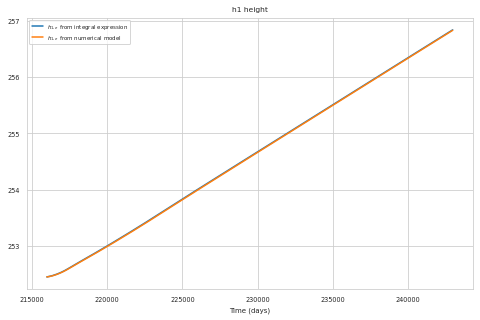

In [29]:
#Check our solution for eastern boundary height vs the true eastern boundary height

fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h1_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

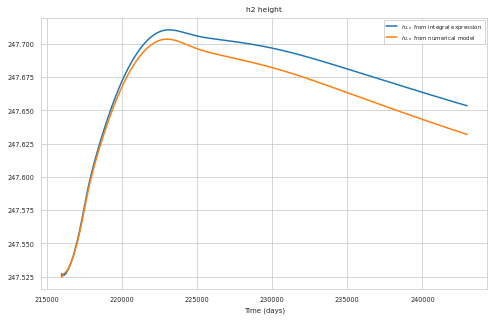

In [30]:
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h2_xr_top[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h2_xr_top[24:,127,:].time[0:4444],h2_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [31]:
#Predict the height throughout the basin using lag equation at the END TIME

pred_h1_toppert_grid=np.zeros([129-30,128-wbc]) #h1 height in the top perturbation experiment
pred_h2_toppert_grid=np.zeros([129-30,128-wbc]) #h2 height in the top perturbation experiment
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0:
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*h1_xr_top[j-30,i-wbc,0]+b4_1*h2_xr_top[j-30,i-wbc,0]
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*h1_xr_top[j-30,i-wbc,0]+b4_2*h2_xr_top[j-30,i-wbc,0]

#convert these all to xarrays
h1_pred_toppert=xr.DataArray(pred_h1_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_toppert=xr.DataArray(pred_h2_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

Text(0.5, 1.05, 'Prediction throughout basin at 75 years with a top layer perturbation. Wind.')

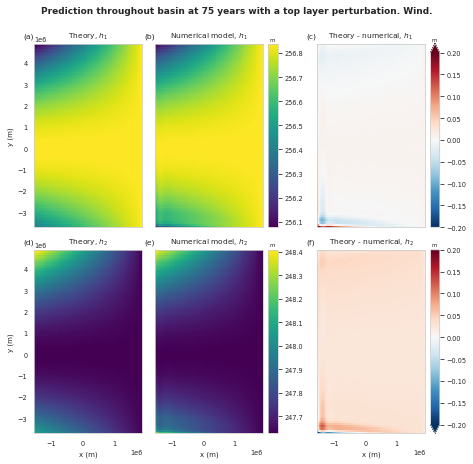

In [32]:
import seaborn as sns
sns.set_style("whitegrid")

scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)
#fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(21,16),  gridspec_kw={'width_ratios': [0.8, 1, 1]})

(h1_pred_toppert[:-ny//7,:]).plot(ax=ax7,edgecolor='face',add_colorbar=False)
ax7.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax7.set_title(r'Theory, $h_1$')
ax7.set_title('(a)',loc='left',x=-0.1)

(h1_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax8,edgecolor='face')
ax8.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax8.set_title('(b)',loc='left',x=-0.1)
#ax8.set_title('m',loc='right',x=1.12)
ax8.set_title(r'Numerical model, $h_1$')



(h1_pred_toppert[:-ny//7]-h1_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax9,vmax=0.2,edgecolor='face')
ax9.set_title(r'Theory - numerical, $h_1$')
ax9.set_title('(c)',loc='left',x=-0.1)
#ax9.set_title('m',loc='right',x=1.12)



(h2_pred_toppert[:-ny//7,:]).plot(ax=ax10,edgecolor='face',add_colorbar=False)
ax10.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax10.set_title(r'Theory, $h_2$')
ax10.set_title('(d)',loc='left',x=-0.1)


(h2_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax11,edgecolor='face')
ax11.clabel(contour_lines, inline=True, fontsize=12*scaling, fmt="%.2f")
ax11.set_title(r'Numerical model, $h_2$')
ax11.set_title('(e)',loc='left',x=-0.1)

(h2_pred_toppert[:-ny//7]-h2_xr_top[30:-ny//7,wbc:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax12,vmax=0.2,edgecolor='face')
ax12.set_title(r'Theory - numerical, $h_2$')
ax12.set_title('(f)',loc='left',x=-0.1)


fig.text(0.57, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.57, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)


fig.text(0.918, 0.973, 'm', ha='left', va='center', fontsize=11*scaling)
fig.text(0.918, 0.4993, 'm', ha='left', va='center', fontsize=11*scaling)



ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('x (m)')
ax11.set_xlabel('x (m)')
ax12.set_xlabel('x (m)')
ax7.set_ylabel('y (m)')
ax8.set_ylabel('')
ax9.set_ylabel('')
ax10.set_ylabel('y (m)')
ax11.set_ylabel('')
ax12.set_ylabel('')


ax8.set_yticks([])
ax9.set_yticks([])
ax11.set_yticks([])
ax12.set_yticks([])


ax7.set_xticks([])
ax8.set_xticks([])
ax9.set_xticks([])


fig.suptitle('Prediction throughout basin at 75 years with a top layer perturbation. Wind.', fontsize=18*scaling,y=1.05, fontweight='bold')

## 3a. Make a prediction at every time instead of just the end time

In [35]:
#Predict at every time
pred_h1_toppert_grid_time=np.zeros([129-30,128-wbc,int(np.shape(h1_east_est)[0]/11)]) #h1 height in the top perturbation experiment
pred_h2_toppert_grid_time=np.zeros([129-30,128-wbc,int(np.shape(h1_east_est)[0]/11)]) #h2 height in the top perturbation experiment
for l in range(0,int(np.shape(h1_east_est)[0]/11)):
    if l<int(np.shape(h1_east_est)[0]/11):
        k=l*11
    if l==int(np.shape(h1_east_est)[0]/11):
        k=l*11-1
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0:
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_toppert_grid_time[j-30,i-wbc,l]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_toppert_grid_time[j-30,i-wbc,l]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_toppert_grid_time[j-30,i-wbc,l]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*np.array(h1_xr_top[j-30,i-wbc,0])+b4_1*np.array(h2_xr_top[j-30,i-wbc,0])
                    pred_h2_toppert_grid_time[j-30,i-wbc,l]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*np.array(h1_xr_top[j-30,i-wbc,0])+b4_2*np.array(h2_xr_top[j-30,i-wbc,0])
            else:
                pred_h1_toppert_grid_time[j-30,i-wbc,l]=b1_1*np.array(h1_xr_top[j-30,i-wbc,0])+b2_1*np.array(h2_xr_top[j-30,i-wbc,0])+b3_1*np.array(h1_xr_top[j-30,i-wbc,0])+b4_1*np.array(h2_xr_top[j-30,i-wbc,0])
                pred_h2_toppert_grid_time[j-30,i-wbc,l]=b1_2*np.array(h1_xr_top[j-30,i-wbc,0])+b2_2*np.array(h2_xr_top[j-30,i-wbc,0])+b3_2*np.array(h1_xr_top[j-30,i-wbc,0])+b4_2*np.array(h2_xr_top[j-30,i-wbc,0])

    print(k)

0
11
22
33
44
55
66
77
88
99
110
121
132
143
154
165
176
187
198
209
220
231
242
253
264
275
286
297
308
319
330
341
352
363
374
385
396
407
418
429
440
451
462
473
484
495
506
517
528
539
550
561
572
583
594
605
616
627
638
649
660
671
682
693
704
715
726
737
748
759
770
781
792
803
814
825
836
847
858
869
880
891
902
913
924
935
946
957
968
979
990
1001
1012
1023
1034
1045
1056
1067
1078
1089
1100
1111
1122
1133
1144
1155
1166
1177
1188
1199
1210
1221
1232
1243
1254
1265
1276
1287
1298
1309
1320
1331
1342
1353
1364
1375
1386
1397
1408
1419
1430
1441
1452
1463
1474
1485
1496
1507
1518
1529
1540
1551
1562
1573
1584
1595
1606
1617
1628
1639
1650
1661
1672
1683
1694
1705
1716
1727
1738
1749
1760
1771
1782
1793
1804
1815
1826
1837
1848
1859
1870
1881
1892
1903
1914
1925
1936
1947
1958
1969
1980
1991
2002
2013
2024
2035
2046
2057
2068
2079
2090
2101
2112
2123
2134
2145
2156
2167
2178
2189
2200
2211
2222
2233
2244
2255
2266
2277
2288
2299
2310
2321
2332
2343
2354
2365
2376
2387
2398
2409
24

In [39]:
#convert these all to xarrays
h1_pred_toppert_time=xr.DataArray(pred_h1_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_top.time[0::11]}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_toppert_time=xr.DataArray(pred_h2_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_top.time[0::11]}, dims=["y", "x","time"]) #convert to an xarray 


# Save them so we don't have to run them again if we don't want to
with open('./intermediate_files_cleaned/pred_h1_toppert_grid_time_250m_matchmitgcminput_wind_longerspinup_revisions.npy', 'wb') as f:
    np.save(f,h1_pred_toppert_time)
with open('./intermediate_files_cleaned/pred_h2_toppert_grid_time_250m_matchmitgcminput_wind_longerspinup_revisions.npy', 'wb') as f:
    np.save(f,h2_pred_toppert_time)